# Create yearly mill usage profile based on measured usage

This notebook will follow a very similar approach to the welder notebook here: https://github.com/RadiantLabs/microgrid-appliance-analysis/blob/master/scripts/usage_profiles/welder_usage_profile.ipynb 

I will include a lot less context in this notebook for now. I can fill it out later if needed.

### Definitions
**Usage Profile**: A usage profile is a unitless series of how often the mill is used on an hourly basis throughout a year. Being unitless allows us to apply costs, power or other factors to generate load, throughput or cost profiles. 

**day_hour**: Monday at 2pm is a single `day_hour` for example. Monday at 3pm is a different `day_hour`. There are 24 hours x 7 days = 168 `day_hour`s.

### General Steps
1. Import measured usage data from a mill. This data is in 2 minute increments and the number of mill revolutions every 2 minutes.
2. Create a unitless utilization factor based on RPM. Create a separate factor for both kW and grain (production) throughput.
3. Resample 2 minute data to 1 hour data, summing new utilization factors. 
4. Group data by `day_hour`s and export for web app
5. Generate a yearly profile by randomly sampling measured `day_hour`s and applying them to the rest of the year.
6. Compare stats of yearly usage profile to measured usage profile to make sure we made reasonable assumptions

We probably don't need to interpolate, since we have 5-6 measured values per `day_hour`

### Questions and TODOs
* Set column header for datetime (app needs this)
* Understand why operators run mills consistently at half RPMs or what the full rated load is:
> Amanda: is the engine running harder than full rated load during these times? I think so, because it would then mean that most of the activity is happening around 80% of full rated load, which is normal for a diesel engine
* Find performance curves:
    1. rpm-to-power: From common mills (https://www.alibaba.com/product-detail/Changfa-type-20-hp-S1115-single_60629667381.html?spm=a2700.7724857.normalList.30.48f321e0kzd6H9), we can see that 16.2kW = 2200 RPM which would imply this mill is running at half speed most of the time. Also, we don't know the kW at 1100 where these mills are mostly running 
    2. rpm-to-grain-throughput


### Running this notebook
Jupyter notebooks are very flexible but have problems with out-of-order function executions.
For example, dropping a column once and then trying to drop the same column again because
you're evaluating the same cell will throw an error. 

Go to Cell > Run All from the menu often or if having problems. For final output, always run it.

## Setup & Library Imports

In [1]:
# Reset all variables so that we can 'run all cells' and not get unused variables hanging around
%reset -f

# Most of this comes with anaconda distribution. I thinkt the only one 
# you have to install is:
# conda install pivottablejs
import pandas as pd
from scipy.stats import mode
from pivottablejs import pivot_ui
from collections import defaultdict
from functools import partial
import random
import json
import pytz

# Should have pandas 0.23 or greater. If not and you're using Anaconda for packages, 
# do this in the terminal: `conda update pandas`
pd.__version__    

'0.23.4'

## Import Mill Data

In [2]:
# Uncomment / comment based on the mill you want to analyze

## Rice Mill (Original)
# excel_file_path = 'inputs/RiceHulling_LP_Tanzania 20180908-20181018.xlsx'
# sheet_name = 'RiceHulling_LP_Tanzania'
# output_generator_kw_data_name = 'output/rice_mill_kw_generator_data.json'
# output_generator_grain_data_name = 'output/rice_mill_grain_generator_data.json'
# output_profile_name = 'output/rice_mill_usage_profile.csv'

## Rice Mill (UTC)
excel_file_path = 'inputs/RiceHulling_LP_Tanzania 20180908-20181110_UTC.xlsx'
sheet_name = 'download (1)'
output_generator_kw_data_name = 'output/rice_mill_kw_generator_data.json'
output_generator_grain_data_name = 'output/rice_mill_grain_generator_data.json'
output_profile_name = 'output/rice_mill_usage_profile.csv'

In [3]:
# Import Excel file, specify the sheet & import it into a Pandas Dataframe.
# df is short for Pandas DataFrame - it makes it clearer what this datastructure is
df_measured_2min = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Rename columns so they are shorter and easier to work with.
df_measured_2min = df_measured_2min.rename(columns={'row': 'time_utc', 'value': '2min_count'})

# Keep only relevant columns
df_measured_2min = df_measured_2min[['time_utc', '2min_count']]
df_measured_2min.head()

,time_utc,2min_count
0,2018-09-01 19:47:22.000,10
1,2018-09-01 19:49:22.124,29
2,2018-09-07 14:38:44.000,0
3,2018-09-07 14:40:44.000,0
4,2018-09-07 14:42:44.000,0


In [4]:
# (rows, columns)
df_measured_2min.shape 

(45926, 2)

## Convert Timezone

In [5]:
# To see all timezones available (but select only the first 55 to see Africa): 
# pytz.all_timezones[0:55]  

In [6]:
# There was no Tanzania listed. Nairobi is +3 which is the same as Tanzania
# There should not be a problem with daylight savings time - from my research neither observe it
tanzania_tz = pytz.timezone('Africa/Nairobi')

In [7]:
# Convert date string to proper datetime so we can work with timezones
df_measured_2min['time_utc'] = pd.to_datetime(df_measured_2min['time_utc'])

In [8]:
# Add local time
df_measured_2min['time_local'] = df_measured_2min['time_utc'].dt.tz_localize('utc').dt.tz_convert(tanzania_tz)
df_measured_2min = df_measured_2min
df_measured_2min.head()

,time_utc,2min_count,time_local
0,2018-09-01 19:47:22.000,10,2018-09-01 22:47:22+03:00
1,2018-09-01 19:49:22.124,29,2018-09-01 22:49:22.124000+03:00
2,2018-09-07 14:38:44.000,0,2018-09-07 17:38:44+03:00
3,2018-09-07 14:40:44.000,0,2018-09-07 17:40:44+03:00
4,2018-09-07 14:42:44.000,0,2018-09-07 17:42:44+03:00


In [9]:
# Helper functions for making and matching day_hour columns

def shorten_day_name(day_string):
    """Shorten a day name to the first 4 letters (1Saturday => 1sat)
    This requires a string passed in.
    """
    return day_string[0:4].lower()

def composite_val(day_name, hour):
    """Generate a composite string value that can be used for dictionary 
    keys or other uses.
    For example, 1Saturday at 10am => 1sat_10
    """
    padded_hour = str(hour).zfill(2)
    return "{}_{}".format(shorten_day_name(day_name), padded_hour)

## Calculate RPM
The mill sensor measures rotations every 2 minutes. Calculate RPMs by dividing by 2

In [10]:
def count_to_rpm(count):
    return round(count / 2)

df_measured_2min['rpm'] = df_measured_2min['2min_count'].apply(count_to_rpm)
df_measured_2min.sample(10)

,time_utc,2min_count,time_local,rpm
36900,2018-10-28 19:27:26,0,2018-10-28 22:27:26+03:00,0
21252,2018-10-07 02:20:16,0,2018-10-07 05:20:16+03:00,0
21181,2018-10-06 23:58:16,0,2018-10-07 02:58:16+03:00,0
9907,2018-09-21 08:29:17,0,2018-09-21 11:29:17+03:00,0
19960,2018-10-05 07:16:16,0,2018-10-05 10:16:16+03:00,0
20857,2018-10-06 13:10:16,0,2018-10-06 16:10:16+03:00,0
4832,2018-09-14 07:25:42,0,2018-09-14 10:25:42+03:00,0
38972,2018-10-31 16:17:34,0,2018-10-31 19:17:34+03:00,0
19918,2018-10-05 05:52:16,0,2018-10-05 08:52:16+03:00,0
9620,2018-09-20 22:55:17,0,2018-09-21 01:55:17+03:00,0


## Explore Data

In [11]:
# The data is skewed because most of it is zeros:
df_measured_2min.describe()

,2min_count,rpm
count,45926.000000,45926.000000
mean,130.776793,65.387841
std,487.376202,243.687506
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,2319.000000,1160.000000


In [12]:
# Filter out all zeros and very low RPMs and look at it again:
# df_measured_nozeros = df_measured_2min[df_measured_2min['rpm'] > -100]  # temp: effectively doesn't filter
df_measured_nozeros = df_measured_2min[df_measured_2min['rpm'] > 100]
df_measured_nozeros.sample(10)

,time_utc,2min_count,time_local,rpm
25700,2018-10-13 06:21:44,2164,2018-10-13 09:21:44+03:00,1082
25941,2018-10-13 14:23:44,455,2018-10-13 17:23:44+03:00,228
41105,2018-11-03 15:23:34,1705,2018-11-03 18:23:34+03:00,852
2918,2018-09-11 15:37:42,2114,2018-09-11 18:37:42+03:00,1057
33091,2018-10-23 12:29:26,2201,2018-10-23 15:29:26+03:00,1100
35113,2018-10-26 07:53:26,1469,2018-10-26 10:53:26+03:00,734
40259,2018-11-02 11:11:34,2196,2018-11-02 14:11:34+03:00,1098
23045,2018-10-09 13:51:44,722,2018-10-09 16:51:44+03:00,361
14455,2018-09-27 15:59:06,2020,2018-09-27 18:59:06+03:00,1010
8440,2018-09-19 07:35:17,354,2018-09-19 10:35:17+03:00,177


In [13]:
# pivot_ui(df_measured_nozeros, 
#          rows=['2min_count'],
#          rendererName="Table",
#          aggregatorName="Count")

In [14]:
# Plot histogram of rpm including zeros
df_measured_2min.plot.hist(y='rpm', figsize=(20, 4))

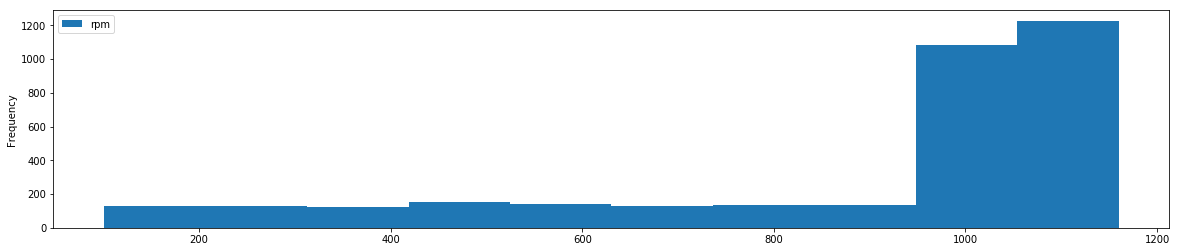

In [15]:
# Plot histogram of rpm excluding zeros and low RPMs
df_measured_nozeros.plot.hist(y='rpm', figsize=(20, 4))

In [16]:
# Most common value (mode):
df_measured_nozeros['rpm'].value_counts().idxmax()

1090

In [17]:
# Add day, hour_of_day, day_hour to 2 minute intervals to see the variation in RPMs with different time intervals
# First set index of dataframe to time_local
df_measured_nozeros = df_measured_nozeros.set_index('time_local')

In [18]:
df_measured_nozeros['day'] = df_measured_nozeros.index.dayofweek.map(str) + df_measured_nozeros.index.day_name()
df_measured_nozeros['day'] = df_measured_nozeros["day"].apply(shorten_day_name)
df_measured_nozeros['hour_of_day'] = df_measured_nozeros.index.hour
df_measured_nozeros['day_hour'] = df_measured_nozeros.apply(lambda row: composite_val(row['day'], row['hour_of_day']), axis=1)
df_measured_nozeros['week'] = df_measured_nozeros.index.week
df_measured_nozeros['rpm_binned'] = pd.cut(df_measured_nozeros['rpm'], 5, precision=0, )
df_measured_nozeros.sample(10)

,time_utc,2min_count,rpm,day,hour_of_day,day_hour,week,rpm_binned
time_local,,,,,,,,
2018-11-06 18:11:34+03:00,2018-11-06 15:11:34,315,158,1tue,18,1tue_18,45,"(100.0, 313.0]"
2018-09-29 16:26:16+03:00,2018-09-29 13:26:16,946,473,5sat,16,5sat_16,39,"(313.0, 525.0]"
2018-10-21 17:39:26+03:00,2018-10-21 14:39:26,225,112,6sun,17,6sun_17,42,"(100.0, 313.0]"
2018-10-19 18:09:44+03:00,2018-10-19 15:09:44,2150,1075,4fri,18,4fri_18,42,"(948.0, 1160.0]"
2018-09-12 18:05:42+03:00,2018-09-12 15:05:42,2047,1024,2wed,18,2wed_18,37,"(948.0, 1160.0]"
2018-10-16 16:33:44+03:00,2018-10-16 13:33:44,2169,1084,1tue,16,1tue_16,42,"(948.0, 1160.0]"
2018-10-01 16:18:16+03:00,2018-10-01 13:18:16,2031,1016,0mon,16,0mon_16,40,"(948.0, 1160.0]"
2018-09-24 18:57:06+03:00,2018-09-24 15:57:06,579,290,0mon,18,0mon_18,39,"(100.0, 313.0]"
2018-10-02 18:30:16+03:00,2018-10-02 15:30:16,348,174,1tue,18,1tue_18,40,"(100.0, 313.0]"


In [19]:
pivot_ui(df_measured_nozeros, 
         rows=['rpm_binned'],
         cols=['hour_of_day'],
         rendererName="Bar Chart",
         aggregatorName="Count")

In [20]:
pivot_ui(df_measured_nozeros, 
         rows=['rpm_binned'],
         cols=['day'],
         rendererName="Bar Chart",
         aggregatorName="Count")

#### Thoughts
* We're seeing the RPM average and mode as ~1000. We think the max RPM is 2200. We are measuring rotations every 2 minutes but 2 minutes is fairly long. Is it possible these mills cycle on and off (or low rpms) within those 2 minutes? For example, they could run at max for 30 seconds, spin down to low RPMs for 30, then spin back up to max continuously? 
    1. The data could support that type of cycling if that behavior was programmed into the mill
    2. The data is too consistent to support people manually cycling these mills. I would expect more variance in the distributions of RPMs.

## Approach to convert RPM to unitless usage counts
RPMs relate to 3 quantities that we care about:
* kW
* kWh
* Grain throughput

These quantities are directly related to costs and revenue for the appliance owner and grid operator. We have measured revolution count in 2-minute intervals. The average RPM is half the number of mill revolutions.

However, if we want to work with hourly intervals, then we can't add up RPMs to get the total RPMs within an hour. We have a few options:
1. Average the RPMs across the hour. If the mill runs for 30 minutes at 1200 RPMs, then the average would be 600 RPMs. Grain throughput and kW likely have a non-linear relationship to RPMs, so this would really distort the results.
2. Assign a unitless usage factor to each minute interval. If the mill is running at full production (throughput and kW), then we can assign it a value of 1 (2 for a 2-minute interval). We can scale the factor down as the RPMs go down. 

The second approach is what I will use.

### Throughput vs. kW
To calculate kW (and therefore kWh) and throughput, we need to know how RPM relates to these two factors. There is no reason to assume the kW and grain throughput vs RPM scale the same. So let's create two functions that calculate kW and grain throughput independently.

For now, these factors will be the same. But the functions can be easily modified as we get more information without refactoring code downstream.

## RPM to unitless utilization factors
This mill is likely rated at 16.2kW @ 2200 RPM. Let's assume some function that relates it's utilization given an RPM.

In [21]:
# What we have measured from the mill sensors is revolutions per 2 minutes: `rp2m`. (At this point we've already converted to rpm by dividing it by 2)
# What we want is the percent that this mill is fully utilized over the course of an hour: `kw_factor`.
# This will allow us to multiply this factor by the appliance power (nominal power in kW) to get the kW for that hour.
# This should stay true as long as kW scales linearly with RPM. We can refine later as we get more data.

# We may want to filter very low RPMs out. A slow motor still uses power and mills grain, but I don't know the cutoff
# Assuming we have already 
def rpm_to_kw_utilization(rpm, full_capacity=1110):
    """
    Convert RPM to a kW utilization factor. 
    This assumes we have already converted the 2-minute revolution count (rp2m) count to 1 minute (rpm) 
    """
    # Fraction of full capacity over 2 minutes 
    two_min_rpm_full_capacity_percent = rpm / full_capacity
    
    # There are 30 2-minute intervals in an hour
    two_min_intervals_per_hour_count = 30
    
    # Calculate the fraction of full utilization for the *entire hour* this 2 minute interval
    # contributes. Then when we resample fromm 2min to 1 hour intervals, these will sum correctly.
    # This is a little unintuitive - we could divide by 30 after resampling, but then this 
    # calculation is spread out across this notebook and may be more confusing
    return round(two_min_rpm_full_capacity_percent / two_min_intervals_per_hour_count, 5)
    
rpm_to_kw_utilization(1121)

0.03366

In [22]:
# Until we have better data, assume the utilization factors are the same between kW and grain
# See explanation above

def rpm_to_grain_utilization(rpm, full_capacity=1110):
    """
    Convert RPM to a grain milled utilization factor
    """
    # Fraction of full capacity over 2 minutes 
    two_min_rpm_full_capacity_percent = rpm / full_capacity
    
    # There are 30 2-minute intervals in an hour
    two_min_intervals_per_hour_count = 30
    
    # Calculate the fraction of full utilization for the *entire hour* this 2 minute interval
    # contributes. Then when we resample fromm 2min to 1 hour intervals, these will sum correctly.
    # This is a little unintuitive - we could divide by 30 after resampling, but then this 
    # calculation is spread out across this notebook and may be more confusing
    return round(two_min_rpm_full_capacity_percent / two_min_intervals_per_hour_count, 5)

rpm_to_grain_utilization(1121)

0.03366

In [23]:
df_measured_2min['kw_factor'] = df_measured_2min['rpm'].apply(rpm_to_kw_utilization) 
df_measured_2min['production_factor'] = df_measured_2min['rpm'].apply(rpm_to_grain_utilization) 

# Show a single hour: 
df_measured_2min[30220:30250]

,time_utc,2min_count,time_local,rpm,kw_factor,production_factor
30220,2018-10-19 13:01:44,2208,2018-10-19 16:01:44+03:00,1104,0.03315,0.03315
30221,2018-10-19 13:03:44,2201,2018-10-19 16:03:44+03:00,1100,0.03303,0.03303
30222,2018-10-19 13:05:44,2219,2018-10-19 16:05:44+03:00,1110,0.03333,0.03333
30223,2018-10-19 13:07:44,2225,2018-10-19 16:07:44+03:00,1112,0.03339,0.03339
30224,2018-10-19 13:09:44,2221,2018-10-19 16:09:44+03:00,1110,0.03333,0.03333
30225,2018-10-19 13:11:44,2208,2018-10-19 16:11:44+03:00,1104,0.03315,0.03315
30226,2018-10-19 13:13:44,2205,2018-10-19 16:13:44+03:00,1102,0.03309,0.03309
30227,2018-10-19 13:15:44,2204,2018-10-19 16:15:44+03:00,1102,0.03309,0.03309
30228,2018-10-19 13:17:44,2192,2018-10-19 16:17:44+03:00,1096,0.03291,0.03291
30229,2018-10-19 13:19:44,2168,2018-10-19 16:19:44+03:00,1084,0.03255,0.03255


In [24]:
# df_measured_2min[30220:30250].to_csv('test_summation', index_label='index')

In [25]:
# Sum the kw_factor for this hour: 2018-10-19 16:00 (axis=0 is column)
# You can see the utilization kw_factor is 0.87098. This is the same as that same hour after resampling to hourly
df_measured_2min[30220:30250].sum(axis=0)

2min_count           58018.00000
rpm                  29006.00000
kw_factor                0.87098
production_factor        0.87098
dtype: float64

## Resample 2 minute to hourly intervals

In [26]:
# First we need to set the dataframe index to be the time_local datetime
df_measured_2min_index = df_measured_2min.set_index('time_local')

In [27]:
df_measured_2min_index.shape

(45926, 5)

In [28]:
# Resample while summing every 2-min interval within an hour ('H')
# Drop the now-unused 2min_count
# UTC time will automatically be dropped since you can't sum it
df_measured = df_measured_2min_index.resample('H').sum().drop(columns=['2min_count'])
df_measured.shape  # (rows, columns) where column count doesn't include the index

(1670, 3)

In [29]:
# This should match the df_measured_2min[30220:30250].sum(axis=0) value for kw_factor above
df_measured['2018-10-19 16:00':'2018-10-19 16:00']

,rpm,kw_factor,production_factor
time_local,,,
2018-10-19 16:00:00+03:00,29006,0.87098,0.87098


## Add hour, day of week, day_hour columns 
These columns will be used later for generating yearly usage profile and aggregate stats.

In [30]:
# Add the name of the day of the week to the dataframe (Saturday).
# Prepend that name with a number of the day of the week.
# Monday is 0, Tuesday is 1 and so on. This will allows tools to 
# order the days so they are in order: 0Monday, 1Tuesday, otherwise 
# they will be ordered alphabetical.
df_measured["day"] = df_measured.index.dayofweek.map(str) + df_measured.index.day_name()
df_measured["day"] = df_measured["day"].apply(shorten_day_name)

# Add hour of day (as a number)
df_measured['hour_of_day'] = df_measured.index.hour 

# Add day_hour. For example: 4fri_10
# Possible source of confusion: 
# 4fri is just friday. 4fri_10 is Friday at 10am. 
df_measured["day_hour"] = df_measured.apply(lambda row: composite_val(row['day'], row['hour_of_day']), axis=1)

df_measured.sample(10)

,rpm,kw_factor,production_factor,day,hour_of_day,day_hour
time_local,,,,,,
2018-09-22 03:00:00+03:00,0,0.00000,0.00000,5sat,3,5sat_03
2018-09-14 15:00:00+03:00,6006,0.18035,0.18035,4fri,15,4fri_15
2018-09-06 10:00:00+03:00,0,0.00000,0.00000,3thu,10,3thu_10
2018-10-01 23:00:00+03:00,0,0.00000,0.00000,0mon,23,0mon_23
2018-09-20 22:00:00+03:00,0,0.00000,0.00000,3thu,22,3thu_22
2018-09-09 13:00:00+03:00,0,0.00000,0.00000,6sun,13,6sun_13
2018-09-27 17:00:00+03:00,6220,0.18679,0.18679,3thu,17,3thu_17
2018-09-27 09:00:00+03:00,887,0.02664,0.02664,3thu,9,3thu_09
2018-09-09 16:00:00+03:00,31370,0.94200,0.94200,6sun,16,6sun_16


## Generate data for yearly usage profile sampling

In [31]:
def create_usage_profile_data(df, column):
    """
    Create a dictionary, where each key is a day_hour and each value 
    is a list of measured usage factor values. 
    Takes a Pandas dataframe and returns a python dictionary that can be 
    encoded into JSON for other applications.
    We may be able to use groupby for a more succinct function, but this works
    """
    dict = defaultdict(list)
    for index, row in df.iterrows():
        key = row['day_hour']
        dict[key].append(row[column])
    return dict

In [32]:
measured_usage_kw_factors = create_usage_profile_data(df_measured, 'kw_factor')
# measured_usage_kw_factors

In [33]:
measured_usage_grain_factors = create_usage_profile_data(df_measured, 'production_factor')
# measured_usage_grain_factors

## Export usage data for web app

In [34]:
with open(output_generator_kw_data_name, 'w') as fp:
    json.dump(measured_usage_kw_factors, fp)
    
with open(output_generator_grain_data_name, 'w') as fp:
    json.dump(measured_usage_grain_factors, fp)

## Generating yearly usage profile
Now that we have usage profile data, generate a complete year's usage profile

In [35]:
def create_year_range_df(year=2018):
    """
    Creates a dataframe with a full year's dates as the index. 
    Add extra derived columns based on that datetime index: 
    (hour, day, hour_of_day, day_hour).
    This dataframe does not contain any appliance data
    """
    start_date_str = '1/1/{}'.format(year + 1)
    start_date = pd.to_datetime(start_date_str) - pd.Timedelta(days=365)
    hourly_periods = 8760
    date_range = pd.date_range(start_date, periods=hourly_periods, freq='H')
    year_hours = list(range(len(date_range)))
    
    # Create a full year with a datetime index (8760 hours)
    df_year = pd.DataFrame({"hour": year_hours}, index=date_range)
    
    # Now add day of week, hour of day and day_hour columns
    df_year['day'] = df_year.index.dayofweek.map(str) + df_year.index.day_name()
    df_year['day'] = df_year["day"].apply(shorten_day_name)
    df_year['hour_of_day'] = df_year.index.hour
    df_year["day_hour"] = df_year.apply(lambda row: composite_val(row['day'], row['hour_of_day']), axis=1)
    return df_year

# Uncomment these to test results. 
# This function is called from generate_usage_profile() 
# df_year_example = create_year_range_df()
# df_year_example.head()

In [36]:
#df_year['kw_factor'] = df_year.apply(partial(sample_usage_index, kw_factor), axis=1)
# df_year['production_factor'] = df_year.apply(partial(sample_usage_index, production_factor), axis=1) 


def sample_usage_index(usage_factors, day_hour):
    """
    Takes the measured usage dictionary and a dataframe row
    from the empty yearly profile created in create_year_range_df. 
    Using the day_hour from that dataframe row, take a random
    sample of the same day_hour from the measured data.
    """
    choice_index_range = range(len(usage_factors[day_hour]))
    return random.choice(choice_index_range)
    

def generate_usage_profile(kw_factors, production_factors, year=2018):
    """
    Generate a full year's usage profile by sampling measured data 
    Takes the measured usage dictionary for both kW and grain factor
    and optional year.
    Returns a dataframe of hourly intevals with sampled appliance values
    """
    # Create dataframe with a full year of hourly intervals
    df_year = create_year_range_df(year)

    # We need to make sure we take the same sample from both kw_factors and production_factors
    # So instead of returning a factor from the sampling, return an index of the list of factors  
    for row_index, row in df_year.iterrows():
        day_hour = row['day_hour']
        usage_index = sample_usage_index(kw_factors, day_hour)
        
        # Add new columns with the sample values
        df_year.at[row_index, 'kw_factor'] = kw_factors[day_hour][usage_index]
        df_year.at[row_index, 'production_factor'] = production_factors[day_hour][usage_index]
        
    return df_year


df_generated_usage_profile = generate_usage_profile(measured_usage_kw_factors, measured_usage_grain_factors)
df_generated_usage_profile.head(10)

,hour,day,hour_of_day,day_hour,kw_factor,production_factor
2018-01-01 00:00:00,0,0mon,0,0mon_00,0.0,0.0
2018-01-01 01:00:00,1,0mon,1,0mon_01,0.0,0.0
2018-01-01 02:00:00,2,0mon,2,0mon_02,0.0,0.0
2018-01-01 03:00:00,3,0mon,3,0mon_03,0.0,0.0
2018-01-01 04:00:00,4,0mon,4,0mon_04,0.0,0.0
2018-01-01 05:00:00,5,0mon,5,0mon_05,0.0,0.0
2018-01-01 06:00:00,6,0mon,6,0mon_06,0.0,0.0
2018-01-01 07:00:00,7,0mon,7,0mon_07,0.0,0.0
2018-01-01 08:00:00,8,0mon,8,0mon_08,0.0,0.0
2018-01-01 09:00:00,9,0mon,9,0mon_09,0.0,0.0


In [37]:
df_generated_usage_profile.describe()

,hour,hour_of_day,kw_factor,production_factor
count,8760.000000,8760.000000,8760.000000,8760.000000
mean,4379.500000,11.500000,0.053675,0.053675
std,2528.938512,6.922582,0.124905,0.124905
min,0.000000,0.000000,0.000000,0.000000
25%,2189.750000,5.750000,0.000000,0.000000
50%,4379.500000,11.500000,0.000000,0.000000
75%,6569.250000,17.250000,0.027053,0.027053
max,8759.000000,23.000000,0.942000,0.942000


In [38]:
# Measured Hourly Averages
pivot_ui(df_measured,
        cols=['hour_of_day'],
        rendererName='Table Barchart',
        aggregatorName='Average',
        vals=['kw_factor'])

In [39]:
# ![Screenshot](screenshots/rice_mill_measured_hourly_avg.png)

In [40]:
# Generated Hourly Averages
pivot_ui(df_generated_usage_profile,
        cols=['hour_of_day'],
        rendererName='Table Barchart',
        aggregatorName='Average',
        vals=['kw_factor'])

In [41]:
# ![Screenshot](screenshots/rice_mill_generated_hourly_avg.png)

In [42]:
# ![Screenshot](screenshots/rice_mill_measured_daily_avg.png)

In [43]:
# Measured Daily Averages
pivot_ui(df_measured,
        cols=['day'],
        rendererName='Table Barchart',
        aggregatorName='Average',
        vals=['kw_factor'])

In [44]:
# Generated Daily Averages
pivot_ui(df_generated_usage_profile,
        cols=['day'],
        rendererName='Table Barchart',
        aggregatorName='Average',
        vals=['kw_factor'])

In [45]:
# ![Screenshot](screenshots/rice_mill_generated_daily_avg.png)

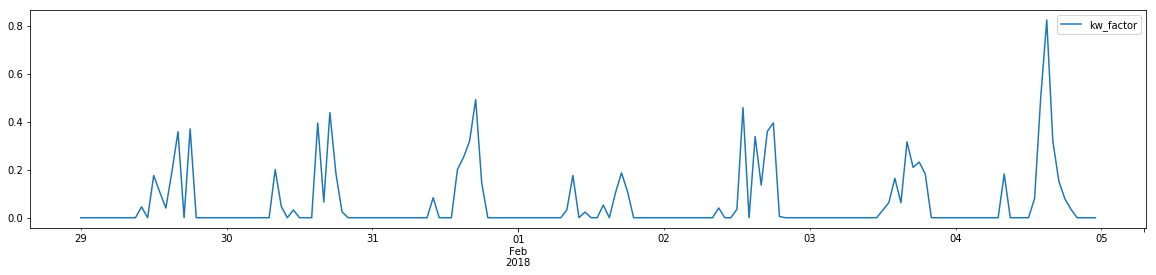

In [46]:
# Show a week's worth of mill usage:
df_week_6 = df_generated_usage_profile.loc[df_generated_usage_profile.index.week == 5]
df_week_6.plot(y='kw_factor', figsize=(20, 4))

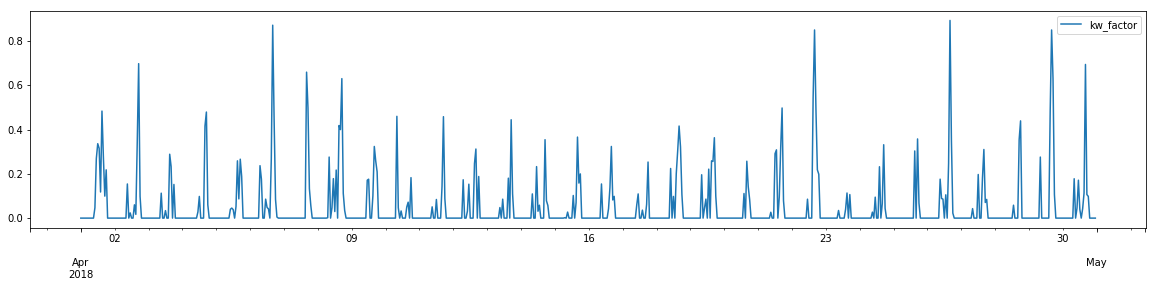

In [47]:
# Show a month's worth of mill usage:
df_february = df_generated_usage_profile.loc[df_generated_usage_profile.index.month == 4]
df_february.plot(y='kw_factor', figsize=(20, 4))

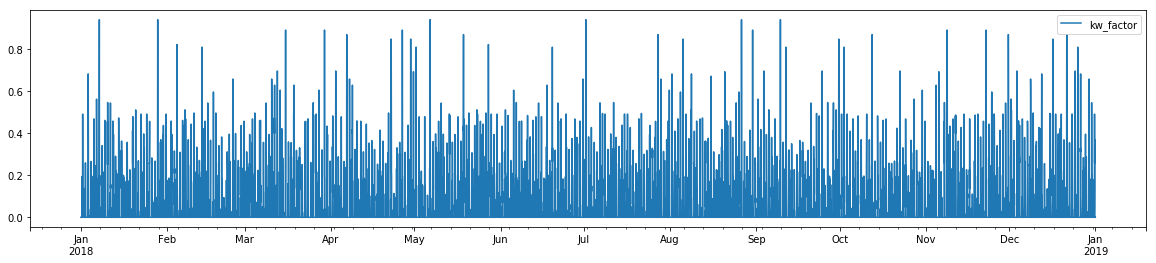

In [48]:
# Show entire year's worth of mill usage:
df_generated_usage_profile.plot(y='kw_factor', figsize=(20, 4))

## Export yearly usage profile 
The web app doesn't need this data but it can be used for other analysis

In [49]:
print("outputting to: ", output_profile_name)
df_generated_usage_profile.to_csv(output_profile_name, index_label='datetime')

outputting to:  output/rice_mill_usage_profile.csv
